state vector dim = 2
n_actions = 3


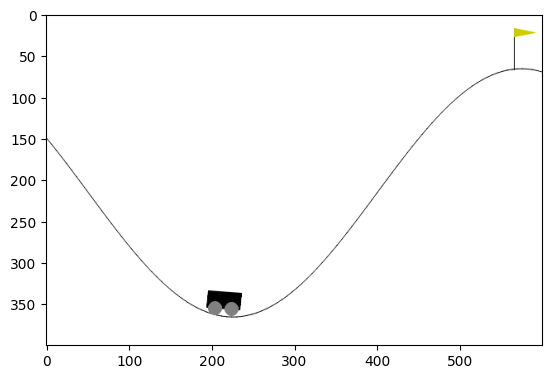

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [2]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50))

In [3]:
def generate_session(env, agent, t_max=10000):
    states, actions = [], []
    total_reward = 0

    state, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([state])[0]
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        action = np.random.choice(list(range(n_actions)), p=probs)
        new_s, reward, terminated, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i in range(len(states_batch)):
      if rewards_batch[i] > reward_threshold:
        elite_states += states_batch[i]
        elite_actions += actions_batch[i]

    return elite_states, elite_actions

In [5]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10], epoch=None, show_plots=True):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print(f"Epoch: {epoch}")
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    if show_plots:
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(list(zip(*log))[0], label="Mean rewards")
        plt.plot(list(zip(*log))[1], label="Reward thresholds")
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards_batch, range=reward_range)
        plt.vlines(
            [np.percentile(rewards_batch, percentile)],
            [0],
            [100],
            label="percentile",
            color="red",
        )
        plt.legend()
        plt.grid()

        plt.show()

Epoch: 199
mean reward = -133.624, threshold=-139.000


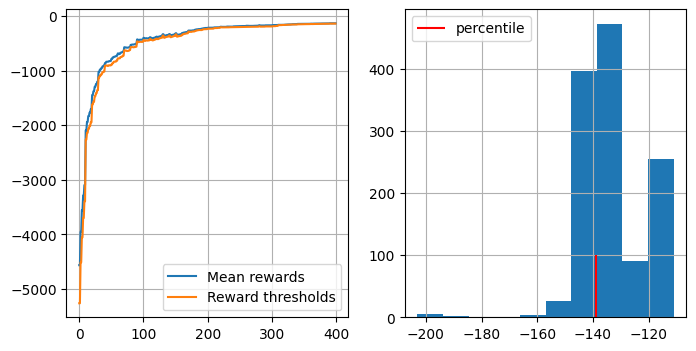

In [6]:
from joblib import Parallel, delayed

n_sessions = 250 #250
percentile = 30 #50
n_cores = 12
log = []

for i in range(200):
    # sessions = [generate_session(env, agent, 10000) for i in range(n_sessions)]
    sessions = Parallel(n_cores)(delayed(generate_session)(gym.make("MountainCar-v0", render_mode="rgb_array").env, agent, 10000) for i in range(n_sessions))
    
    if i%5 == 0:
        states_batch = [el[0] for el in sessions]
        actions_batch = [el[1] for el in sessions]
        rewards_batch = [el[2] for el in sessions]
    else:
        states_batch += [el[0] for el in sessions]
        actions_batch += [el[1] for el in sessions]
        rewards_batch += [el[2] for el in sessions]

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    show_progress(
        rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)], epoch=i
    )

    agent.fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)], epoch=i
    )

    
    if np.mean(rewards_batch) >= -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [8]:
from joblib import dump, load
dump(agent, "./models/agent.pkl") 

['./models/agent.pkl']

Epoch: 0
mean reward = -133.463, threshold=-139.000


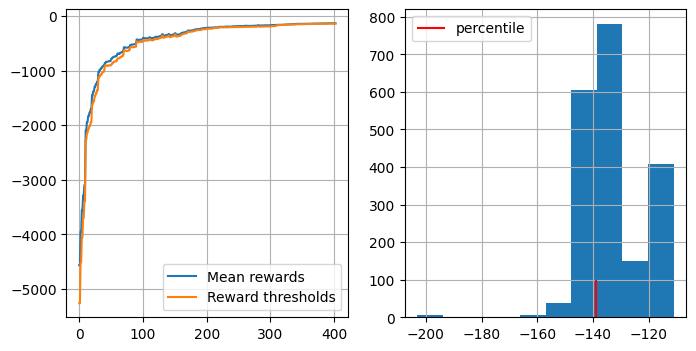

You Win! You may stop training now via KeyboardInterrupt.


In [12]:
model = load("./models/agent.pkl")
sessions = Parallel(n_cores)(delayed(generate_session)(gym.make("MountainCar-v0", render_mode="rgb_array").env, model, 10000) for i in range(n_sessions))

states_batch += [el[0] for el in sessions]
actions_batch += [el[1] for el in sessions]
rewards_batch += [el[2] for el in sessions]

elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

show_progress(
    rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)], epoch=i
)

if np.mean(rewards_batch) >= -150:
    print("You Win! You may stop training now via KeyboardInterrupt.")

c:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(
c:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.min_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.min_position` for environment variables or `env.get_wrapper_attr('min_position')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_position` for environment variables or `env.get_wrapper_attr('max_pos

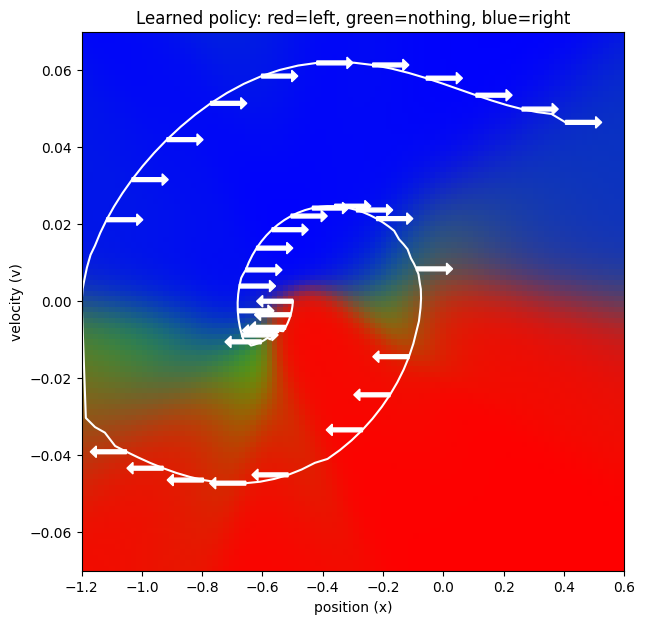

In [13]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, model)